Nachdem wir im letzten Notebook Overfitting gesehen haben, geht es nun darum, etwas gegen Overfitting zu tun: Regularisierung. Ganz unten findet ihr Codebausteine zu den Dingen, die auf den Folien stehen. Diese könnt ihr im Modell einbauen und versuchen, das Overfitting zu vermeiden.

In [ ]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
%%capture
# download and import utils. %%capture supresses output
!pip install wget
import wget 
wget.download("https://raw.githubusercontent.com/jandeller/test/main/tf_intro_utils.py", "utils.py")


from utils import plot_moons, plot_moons_predictions
%matplotlib inline

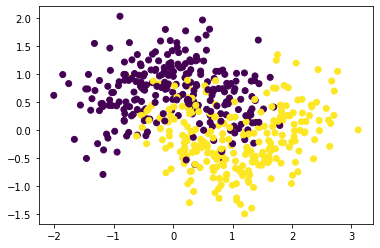

In [ ]:
NOISE_LEVEL = 0.4

X, y = make_moons(n_samples=500, noise=NOISE_LEVEL, random_state=42)
plot_moons(X, y)

Jetzt machen wir es richtig: Neben dem Trainings- und dem Testdatensatz gibt es auch einen Validierungsdatensatz!

In [ ]:
# HIER IST ETWAS NEU
# split into train, validation, test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.fit_transform(X_val)
X_test  = scaler.transform(X_test)

Jetzt beginnen wir mit dem `TensorFlow`-Modell! Nachdem wir `TensorFlow` importiert haben besteht dies aus drei Schritten:
1. Wir spezifizieren das Modell. In dieser Session arbeiten wir nur mit sequentiellen Modellen, in denen wir die Layer Schritt für Schritt als Liste spezifizieren.
2. Dann müssen wir das Modell kompilieren. Dazu müssen wir über `loss` die Loss-Funktion und über `optimizer` den Optimierer angeben. Wir arbeiten mit `keras.optimizers.Adam` - das ist immer eine gute erste Wahl. Die Parameter von diesem Optimierer könnt ihr euch über `keras.optimizers.Adam?` anschauen.
3. Und dann beginnt das Training mit den Trainingsdaten über die `fit`-Methode.

In [ ]:
# And now we use a TensorFlow model
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers

In [ ]:
# HIER IST ETWAS NEU
# specify model - this time a bit too complex
model = keras.Sequential([
    layers.Input(shape=[2]),
    layers.Dense(units=100, activation='relu'),
    layers.Dense(units=500,  activation='relu'),
    layers.Dense(units=200, activation='relu'),
    layers.Dense(units=100,  activation='relu'),
    layers.Dense(units=10, activation='relu'),
    layers.Dense(units=5,  activation='relu'),
    layers.Dense(units=1,  activation='sigmoid')
])

In [ ]:
# plot model
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

Nachdem das Modell spezifiziert und kompiliert wurde, können wir nun die Trainigsdaten nutzen um das Modell zu fitten. Zu Beginn geben wir der `fit`-Methode nur die Trainingsdaten und spezifizieren, wie viele Epochen trainiert wird, d.h., wie oft die Trainingsdaten dem Modell gezeigt werden. In jeder Epoche wird der gesamte Trainingsdatensatz genutzt um das Modell zu trainieren.

Wird die `fit`-Methode auf einem Modell erneut aufgerufen wird das Modell weitertrainiert, die weights und biases werden nicht neu initialisiert. Dies geschieht nur, wenn das Modell neu spezifiziert wird (und dann muss es auch erneut kompiliert werden).

In [ ]:
# HIER IST ETWAS NEU
RUN_NAME = "run1" # ACHTUNG: Den Namen hier bei jedem Run anpassen. Man kann das auch über eine Funktion lösen, die die Uhrzeit des Runs prepended.

import os
os.mkdir("logs") # uncomment this if the dir already exists
tb_callback = keras.callbacks.TensorBoard(f"logs/{RUN_NAME}")

# verbose=0 (do not print training progress) as the output would be super large otherwise
# validation data is not used for training but to test how well the model generalizes
model.fit(X_train, y_train, epochs=500, verbose=0, validation_data=(X_val, y_val), callbacks=[tb_callback]) 

In [ ]:
plot_moons_predictions?

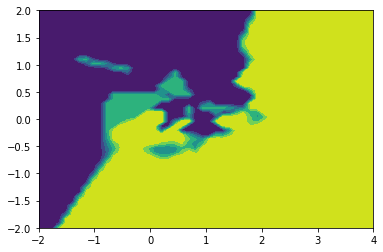

In [ ]:
plot_moons_predictions(X=X, y=y, model=model, scaler=scaler, plot_points=False)

Das sieht nicht so wirklich so aus, als würde es gut generalisieren - dafür ist die decision surface viel zu zersplittert. Hier werden die Trainingsdaten zu sehr auswendig gelernt, wir hätten es lieber etwas smoother.

Das schauen wir uns jetzt nochmal genauer an, und zwar visualisieren wir den Loss auf dem Trainings- und Validierungsdatensatz.

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

In [ ]:
# l1/l2 regularization
# add kernel_regularizer=keras.regularizers.l2(0.01) (or l1 for l1 regularization) to the layer, e.g.,
layers.Dense(10, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))
# note: if you do this quite heavily, maybe check the histogram tab in the tensorboard and see if you can see anything there if you compare it to a model without this regularization

In [ ]:
# dropout
layers.Dropout(rate=0.2) # add this after the layer you want to use dropout on. 0.2 means that each neuron has dropout probability .2

In [ ]:
# early stopping
# early stopping is a callback - instantiate it and add it to the list of callbacks when calling `fit`
early_stopping = keras.callbacks.EarlyStopping(patience=5) # will continue for 5 epochs if validation loss doesn't decrease (because it could be on a plateau and decrease again after not doing so for 3 epochs)

In [ ]:
# simpler model
# that's up to you ;)